# Notebook of comparison VAE and geometric VAE

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import torch
import anndata

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


## Initialize the two different configurations 

General module hparams

In [2]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/hein_et_al/processed/unperturbed_time_course_host_low.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'cluster'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 256, 
            'num_workers': 2}

# Initialize datamodule
datamodule = scDataModule(**datamodule)

### Model config VAE

In [3]:
vae_model_kwargs={'in_dim': datamodule.in_dim,
                  'n_epochs_anneal_kl': 1000, 
                  'kl_weight': None, 
                  'likelihood': 'nb', 
                  'kl_warmup_fraction': 2, 
                  'learning_rate': 0.001, 
                  'dropout': False, 
                  'dropout_p': False, 
                  'model_library_size': False, 
                  'batch_norm': True, 
                  'hidden_dims': [512, 256, 10]}
        
vae_geometric_kwargs=geometric_vae={'compute_metrics_every': 1, 
                                    'use_c': False, 
                                    'l2': True, 
                                    'fl_weight': 1, 
                                    'eta_interp': 0.1, 
                                    'interpolate_z': True, 
                                    'start_jac_after': 5, 
                                    'detach_theta': False}

In [4]:
geometric_model_kwargs={'in_dim': datamodule.in_dim,
                        'n_epochs_anneal_kl': 1000, 
                        'kl_weight': None, 
                        'likelihood': 'nb', 
                        'dropout': False, 
                        'dropout_p': False, 
                        'model_library_size': False, 
                        'batch_norm': True, 
                        'hidden_dims': [512, 256, 10], 
                        'kl_warmup_fraction': 2, 
                        'learning_rate': 0.001}
        
geometric_geometric_kwargs={'compute_metrics_every': 1, 
                            'use_c': False, 
                            'l2': True, 
                            'fl_weight': 100, 
                            'eta_interp': 0.3, 
                            'interpolate_z': True, 
                            'start_jac_after': 0, 
                            'detach_theta': True}

In [5]:
vae = GeometricNBVAE(**vae_geometric_kwargs, vae_kwargs=vae_model_kwargs)
geometric_vae = GeometricNBVAE(**geometric_geometric_kwargs, vae_kwargs=geometric_model_kwargs)

In [6]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al/best_model_vae.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al/best_model_geometric.ckpt")["state_dict"])

<All keys matched successfully>

In [7]:
datamodule.cond_keys

['experimental_time', 'cluster']

### Compute UMAPs

In [8]:
adata_vae_amortized_real, adata_vae_z = real_reconstructed_cells_adata(vae, datamodule, process_amortized_adata=True).values()
adata_geometric_amortized_real, adata_geometric_z = real_reconstructed_cells_adata(geometric_vae, datamodule, process_amortized_adata=True).values()

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Plot the UMAP results

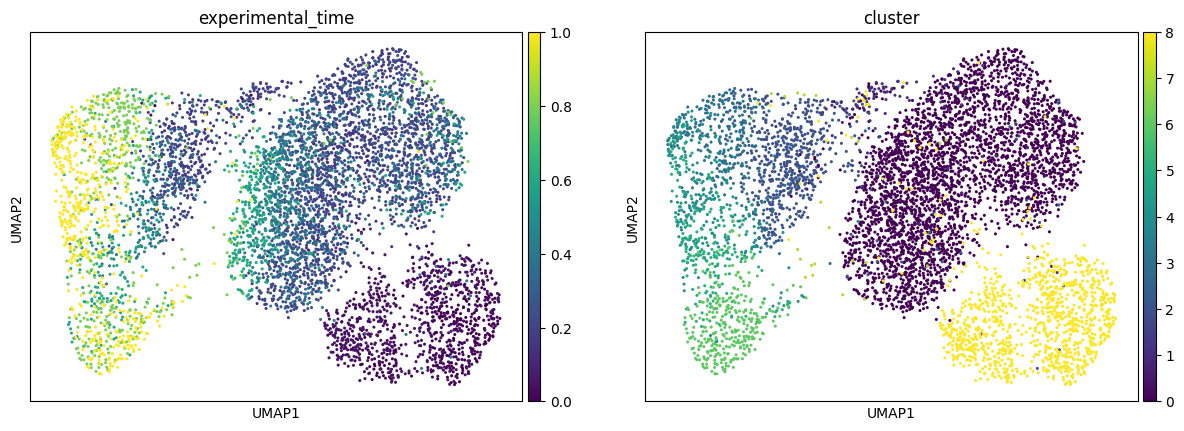

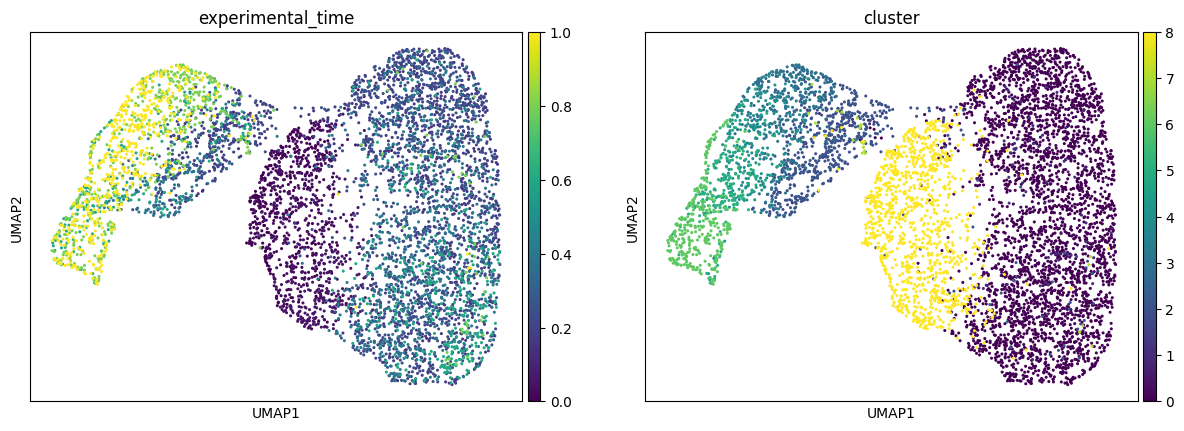

In [9]:
sc.pl.umap(adata_vae_z, color=["experimental_time", "cluster"])
sc.pl.umap(adata_geometric_z, color=["experimental_time", "cluster"])

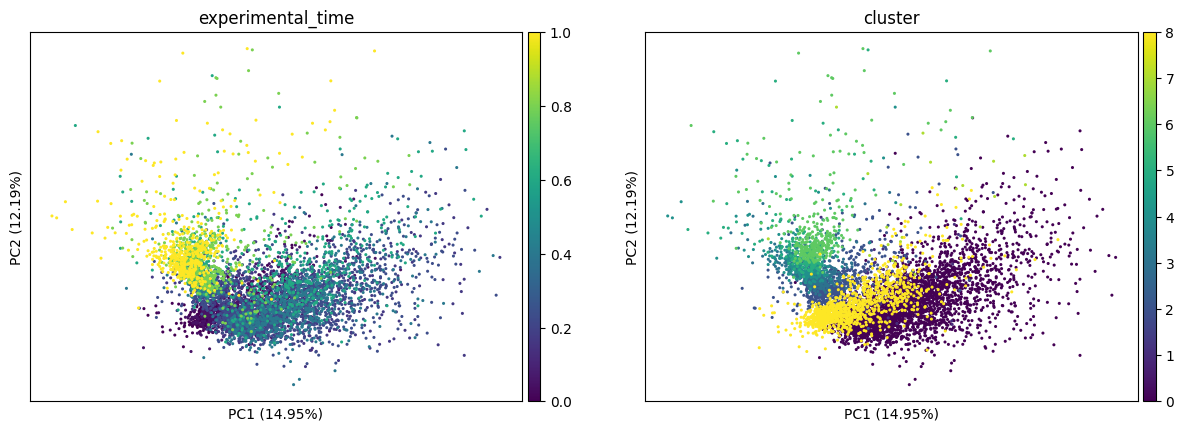

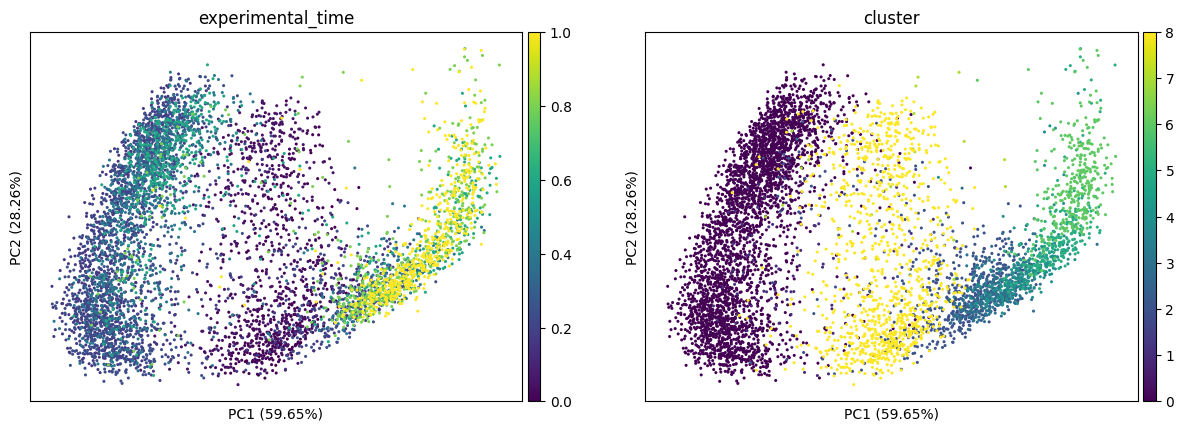

In [10]:
sc.pl.pca(adata_vae_z, color=["experimental_time", "cluster"], annotate_var_explained=True)
sc.pl.pca(adata_geometric_z, color=["experimental_time", "cluster"], annotate_var_explained=True)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


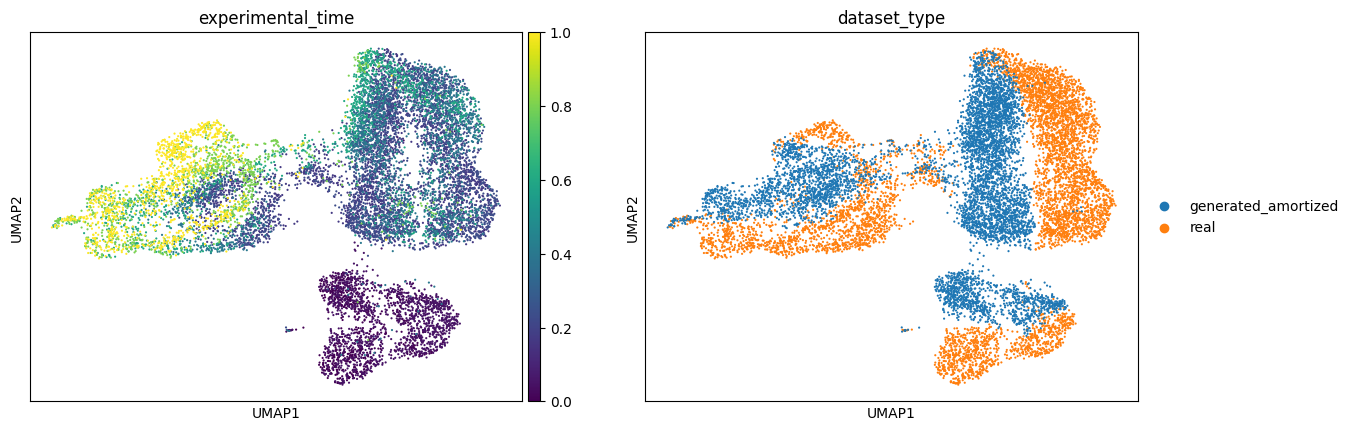

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


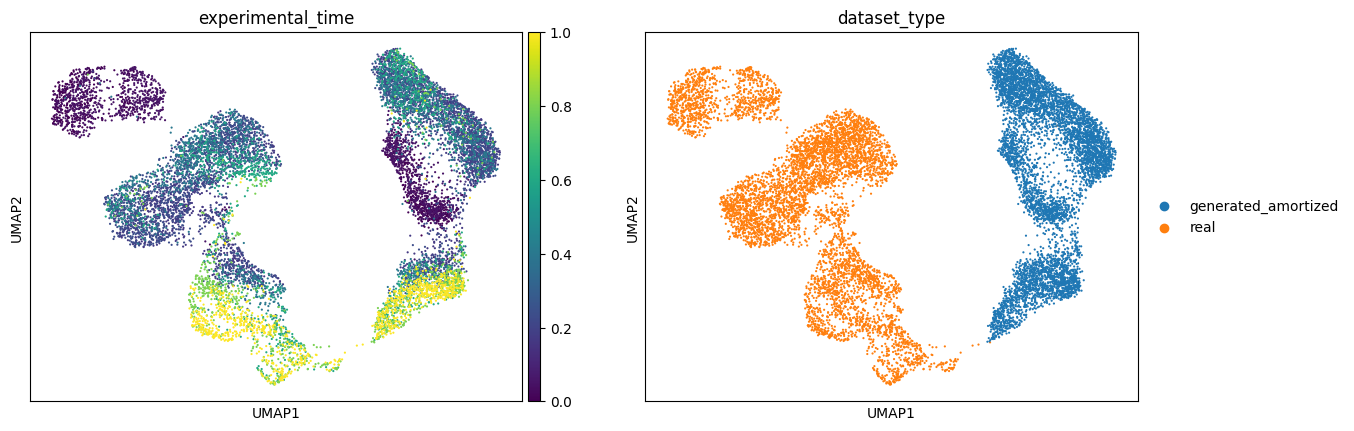

In [11]:
sc.pl.umap(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.umap(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


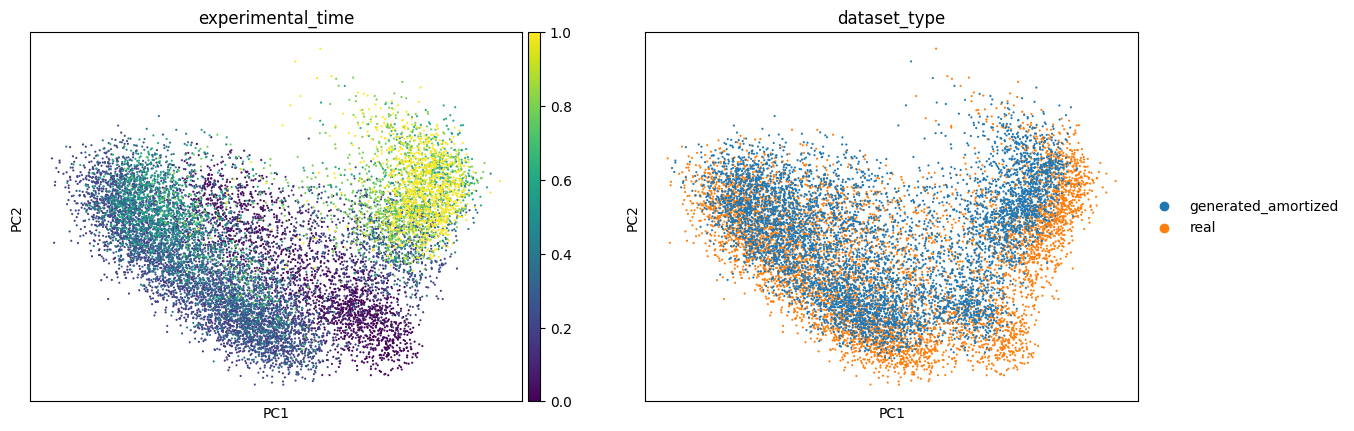

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


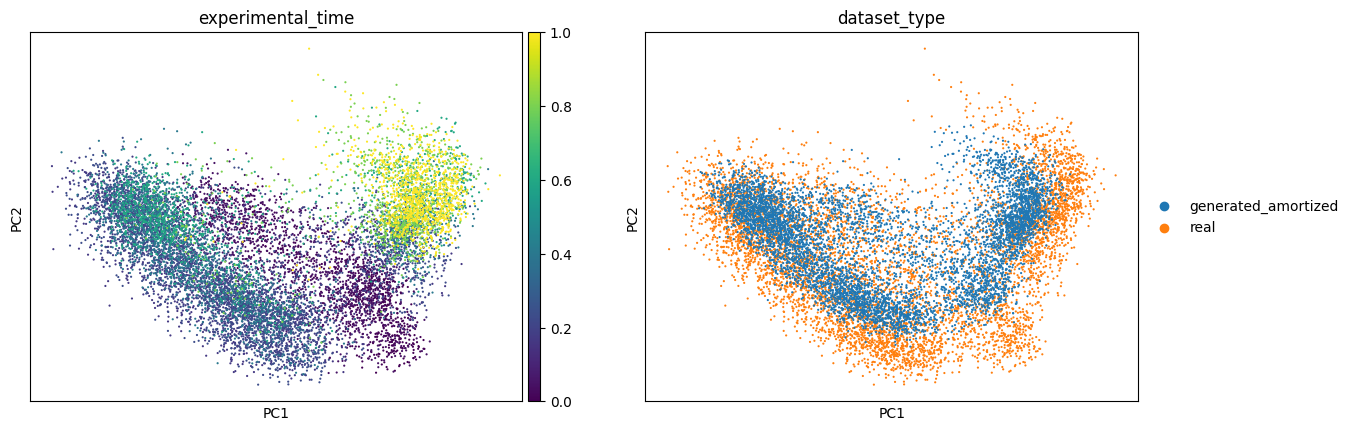

In [12]:
sc.pl.pca(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.pca(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])

In [13]:
adata_amoritzed_real

NameError: name 'adata_amoritzed_real' is not defined

Check reconstruction umap

In [ ]:
# from pytorch_lightning import Trainer

# trainer_vae = Trainer(inference_mode=False)
# trainer_geometric = Trainer(inference_mode=False)

In [ ]:
# trainer_vae.validate(model=vae, dataloaders=datamodule)

In [ ]:
# trainer_geometric.validate(model=geometric_vae, 
#                        dataloaders=datamodule)

**Save anndata**

In [ ]:
# adata_vae_z.layers["X_latents"] = adata_vae_z.X.copy()
# adata_vae_z.write_h5ad(PROJECT_FOLDER / "data/hein_et_al/flat/hein_et_al.h5ad")

In [ ]:
# adata_geometric_z.layers["X_latents"] = adata_geometric_z.X.copy()
# adata_geometric_z.write_h5ad(PROJECT_FOLDER / "data/hein_et_al/flat/hein_et_al_flat.h5ad")

**Plot together**

In [ ]:
annot = ["geometric" for _ in range(len(adata_geometric_z))] + ["normal" for _ in range(len(adata_vae_z))]
concat = anndata.concat([adata_geometric_z, adata_vae_z], merge="same")
concat.obs["dataset_type"] = annot

In [ ]:
sc.tl.pca(concat)
sc.pl.pca(concat, color="dataset_type")

In [ ]:
adata_geometric_z.X.max()

In [ ]:
adata_geometric_z.X.min()

In [ ]:
adata_vae_z.X.max()

In [ ]:
adata_vae_z.X.min()